## Uncertainty in Explanations via Input Perturbation (Vision)

In [1]:
import numpy as np
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import layers, models
from skimage.color import gray2rgb
import matplotlib.pyplot as plt
import cv2

In [2]:
#import sys
#sys.path.append('./xplique/')
from xplique.attributions import (Lime, Saliency, GradientInput, IntegratedGradients, 
                                  SmoothGrad, SquareGrad, VarGrad, Occlusion, Rise,
                                  KernelShap, DeconvNet)

In [3]:
# Load and Prepare MNIST Dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize to [0, 1]
x_train = gray2rgb(x_train)
x_test = gray2rgb(x_test)

In [4]:
# Build and train a simple CNN
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax'),
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=2, batch_size=64, validation_split=0.25)

Epoch 1/2
704/704 [==============================] - 8s 6ms/step - loss: 0.1861 - accuracy: 0.9436 - val_loss: 0.0731 - val_accuracy: 0.9769
Epoch 2/2
704/704 [==============================] - 4s 5ms/step - loss: 0.0584 - accuracy: 0.9817 - val_loss: 0.0541 - val_accuracy: 0.9834


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                102464    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                6

In [9]:
# Explain sample prediction
sample_index = 0
sample_image, sample_label = x_test[sample_index], y_test[sample_index]
sample_image = np.expand_dims(sample_image, axis=0)
sample_label = np.expand_dims(sample_label, axis=0)
sample_image.shape

(1, 28, 28, 3)

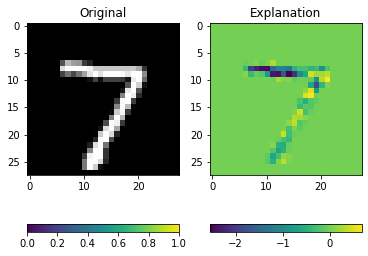

In [10]:
model.layers[-1].activation = tf.keras.activations.linear
#explainer = Saliency(model)
#explainer = GradientInput(model)
explainer = IntegratedGradients(model, steps=80, batch_size=1)
#explainer = SmoothGrad(model, nb_samples=80, batch_size=1)
#explainer = SquareGrad(model, nb_samples=80, batch_size=1)
#explainer = DeconvNet(model)
#explainer = VarGrad(model, nb_samples=80, batch_size=1)
    #explainer = Occlusion(model, patch_size=10, patch_stride=5)
    #explainer = Rise(model, nb_samples=80)
#explainer = Lime(model, nb_samples = 80, batch_size=1)
#explainer = KernelShap(model, nb_samples = 80, batch_size=1)

explanation = explainer.explain(sample_image, sample_label)

# Display explanation
plt.figure(figsize=(6,6))
plt.subplot(121)
plt.imshow(sample_image.squeeze()) # shape (1, 28, 28, 3)
plt.title("Original")
plt.colorbar(orientation='horizontal')
plt.subplot(122)
plt.imshow(explanation[0]) # shape (1, 28, 28)
plt.title("Explanation")
plt.colorbar(orientation='horizontal')
plt.show()

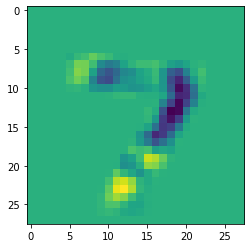

In [7]:
gauss_exp = cv2.GaussianBlur(explanation[0].numpy(), (3,3), 6)
#gauss_exp = cv2.GaussianBlur(explanation[0].numpy(), (3,3), 1)
plt.imshow(gauss_exp);

### Mathematical considerations

Let the explainer be

$$e_{\theta, f}: \mathbb{R}^{n \cdot k \cdot l \cdot r} \rightarrow \mathbb{R}^m$$

with the explanation in the form $e_{\theta, f}(x, \hat{y})$.

Dimensions:

+ $n$: input $x = (x_1, ..., x_n)$
+ $k$: prediction $f(x) = \hat{y} = (\hat{y}_1, ..., \hat{y}_k)$
+ $l$: parameters of the XAI method $\theta = (\theta_1, ..., \theta_l)$ (in case it has any)
+ $r$: model parameters $\omega = (\omega_1, ..., \omega_r)$
+ $m$: explanation $e = (e_1, ..., e_m)$

The (full) Jacobian of the explainer $e$ w.r.t. all the inputs has the form:

$$\mathbb{J}_e = [\frac{\partial e}{\partial x} \frac{\partial e}{\partial \hat{y}} \frac{\partial e}{\partial \theta} \frac{\partial e}{\partial \omega}]$$

If looking only at the sensitivity of the explanation w.r.t. to the input $x$, then the derivative is:

$$\frac{\partial e}{\partial x} = \begin{bmatrix}
\frac{de_1}{dx_1} & ... & \frac{de_1}{dx_n}\\
... & ... & ...\\
\frac{de_m}{dx_1} & ... & \frac{de_m}{dx_n}
\end{bmatrix}$$

$$Var(e(\widetilde{x},\hat{y})) \approx \frac{\partial e}{\partial x}(x,\hat{y}) \cdot \Sigma_{\Delta x} \cdot \frac{\partial e}{\partial x}(x,\hat{y})^T$$

If the perturbance in every pixel is normally distributed with the same variance, then the covariance becomes:

$$\Delta x \sim \mathcal{N}(0, \sigma^2 I), \Sigma_{\Delta x} = \sigma^2 I$$

Hence, the covariance matrix of the explanation becomes:

$$Var(e(\widetilde{x},\hat{y})) \approx \sigma^2 \frac{\partial e}{\partial x}(x,\hat{y}) \cdot \frac{\partial e}{\partial x}(x,\hat{y})^T$$

In [9]:
# Compute derivative of explanation w.r.t input via FDM
# Note: takes up to 5 minutes for Integrated Grads, SmoothGrad
dx = 1e-3 #1e-4
sample_image = sample_image.squeeze()
n = np.product(np.shape(sample_image))
m = np.product(np.shape(explanation))
h, w = sample_image.shape[0], sample_image.shape[1]
derivative_e_x = np.zeros((m, n))

# For every pixel perturbation, we get a new column in the Jacobian
for i in range(h):
    for j in range(w):
        # Perturb pixel (i, j)
        perturbed_image = np.copy(sample_image)
        perturbed_image[i, j] += dx
        perturbed_image = np.clip(perturbed_image, 0, 1)  # Keep within valid range

        # Compute explanation for perturbed image
        perturbed_explanation = explainer.explain(np.expand_dims(perturbed_image, axis=[0,3]), sample_label)

        # Compute finite difference gradient
        #derivative_2d = (perturbed_explanation[0] - explanation[0]) / dx
        gauss_perturbed_exp = cv2.GaussianBlur(perturbed_explanation[0].numpy(), (3,3), 6) # tested sigmas: 6 and 1
        #derivative_2d = (gauss_perturbed_exp - gauss_exp) / dx

        # Normalize the explanations to [0, 1]
        normalized_explanation = (gauss_exp - gauss_exp.min()) / (gauss_exp.max() - gauss_exp.min())
        normalized_perturbed_explanation = (gauss_perturbed_exp - gauss_perturbed_exp.min()) / (gauss_perturbed_exp.max() - gauss_perturbed_exp.min())
        derivative_2d = (normalized_perturbed_explanation - normalized_explanation) / dx

        # Fill out the corresponding column in the jacobian
        flat_ind = i * w + j
        derivative_e_x[:, flat_ind] = derivative_2d.reshape(m, )

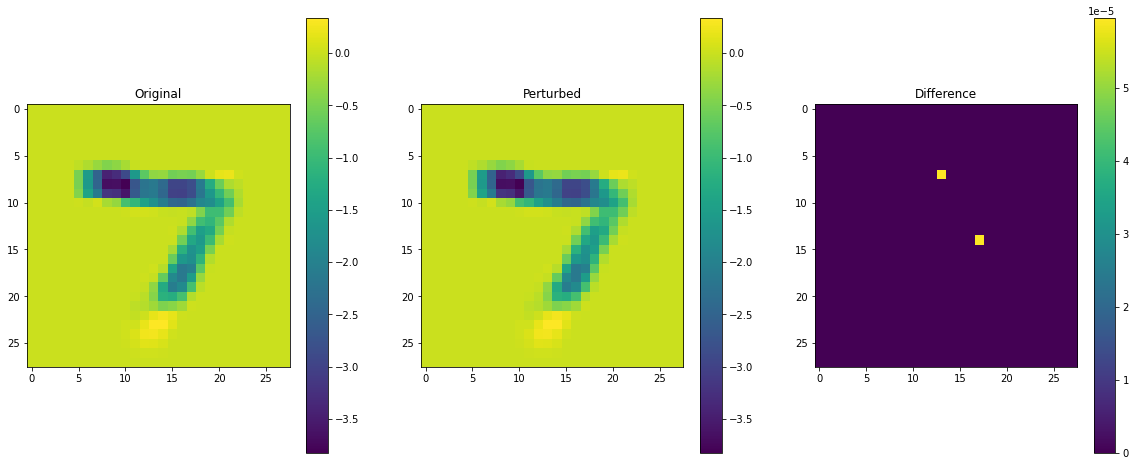

In [10]:
# Display explanation
plt.figure(figsize=(20,8))
plt.subplot(131)
plt.imshow(gauss_exp) # shape (1, 28, 28, 1)
plt.title("Original")
plt.colorbar()
plt.subplot(132)
plt.imshow(gauss_perturbed_exp) # shape (1, 28, 28)
plt.title("Perturbed")
plt.colorbar()
plt.subplot(133)
plt.imshow(np.abs(normalized_perturbed_explanation - normalized_explanation) / dx) # shape (1, 28, 28)
plt.title("Difference")
plt.colorbar()
plt.show()

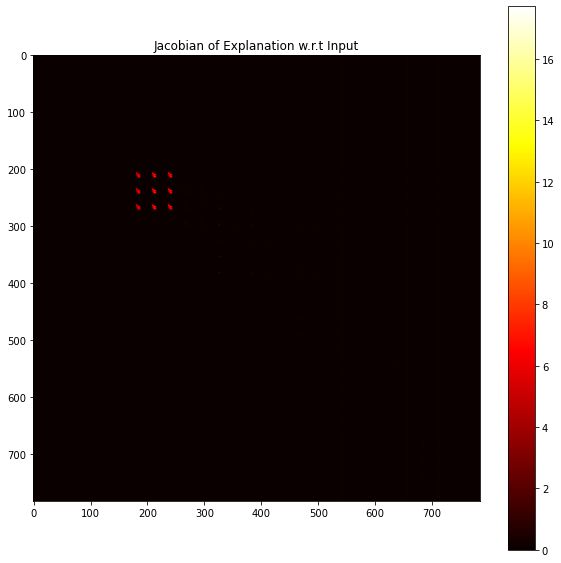

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(np.abs(derivative_e_x), cmap='hot')
plt.title("Jacobian of Explanation w.r.t Input")
plt.colorbar()
plt.show()

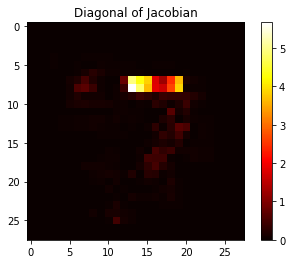

In [12]:
plt.imshow(np.abs(np.diag(derivative_e_x).reshape(h,w)), cmap='hot')
plt.title("Diagonal of Jacobian")
plt.colorbar()
plt.show()

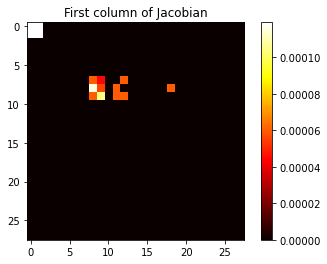

In [13]:
plt.imshow(np.abs(derivative_e_x[:,0].reshape(h,w)), cmap='hot')
plt.title("First column of Jacobian")
plt.colorbar()
plt.show()

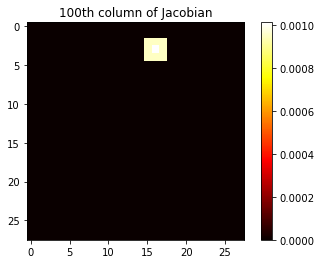

In [14]:
plt.imshow(np.abs(derivative_e_x[:,100].reshape(h,w)), cmap='hot')
plt.title("100th column of Jacobian")
plt.colorbar()
plt.show()

In [15]:
# Approximate covariance of explanation
perturbation_std = 0.1
sigma_squared = perturbation_std ** 2
variance_explanation = sigma_squared * derivative_e_x @ derivative_e_x.T

# Total variance is the trace of the cov. matrix
print("Total Variance of Explanation (Analytical):", np.trace(variance_explanation))

Total Variance of Explanation (Analytical): 249.20330598270203


In [16]:
# Normalized total variance is the trace of the cov. matrix divided by the L2-norm of the unperturbed explanation
print("Normalized Variance of Explanation:", np.trace(variance_explanation) / np.linalg.norm(explanation))

Normalized Variance of Explanation: 8.450162684499418


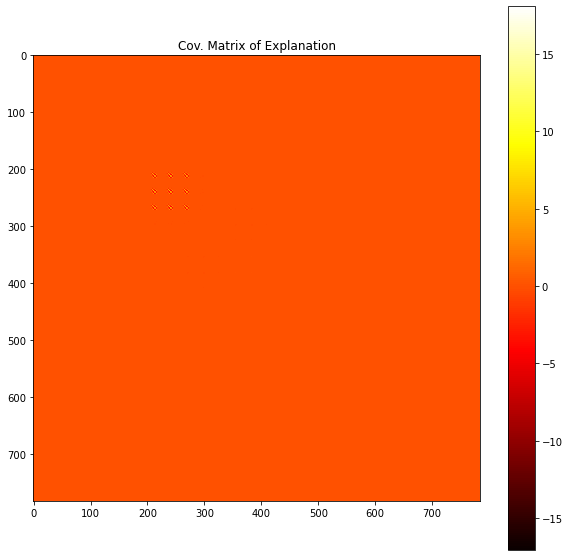

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(variance_explanation, cmap='hot')
plt.title("Cov. Matrix of Explanation")
plt.colorbar()
plt.show()

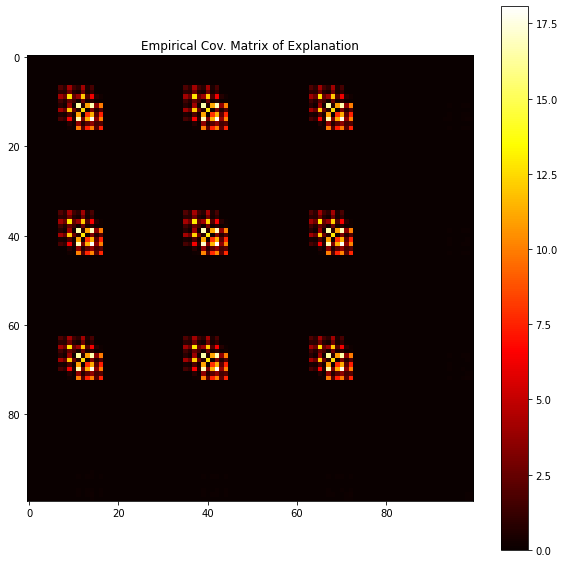

In [31]:
plt.figure(figsize=(10,10))
plt.imshow(np.abs(variance_explanation)[200:300,200:300], cmap='hot')
plt.title("Empirical Cov. Matrix of Explanation")
plt.colorbar()
plt.show()

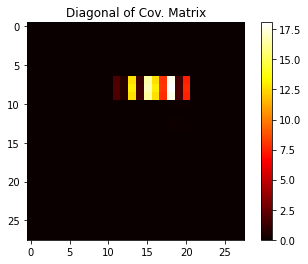

In [18]:
# Per Pixel Variance
plt.imshow(np.abs(np.diag(variance_explanation).reshape(h,w)), cmap='hot')
plt.title("Diagonal of Cov. Matrix")
plt.colorbar()
plt.show()

/home/tchiaburu/anaconda3/envs/tf2_8_gpu/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


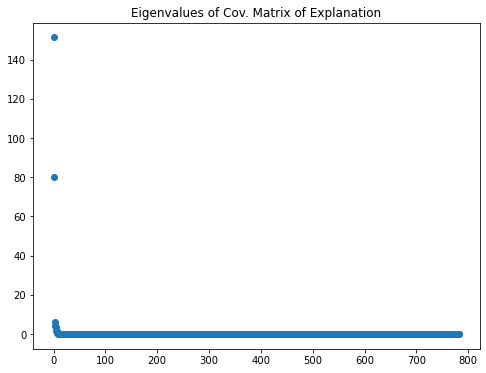

In [19]:
# Explained variance ratio
evals, evecs = np.linalg.eig(variance_explanation)

plt.figure(figsize=(8,6))
plt.plot(evals, 'o')
plt.title('Eigenvalues of Cov. Matrix of Explanation');

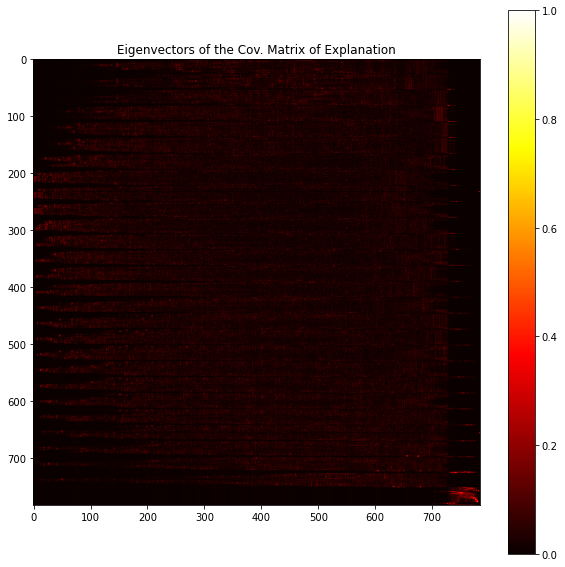

In [20]:
plt.figure(figsize=(10,10))
plt.imshow(np.abs(evecs), cmap='hot')
plt.title("Eigenvectors of the Cov. Matrix of Explanation")
plt.colorbar()
plt.show()

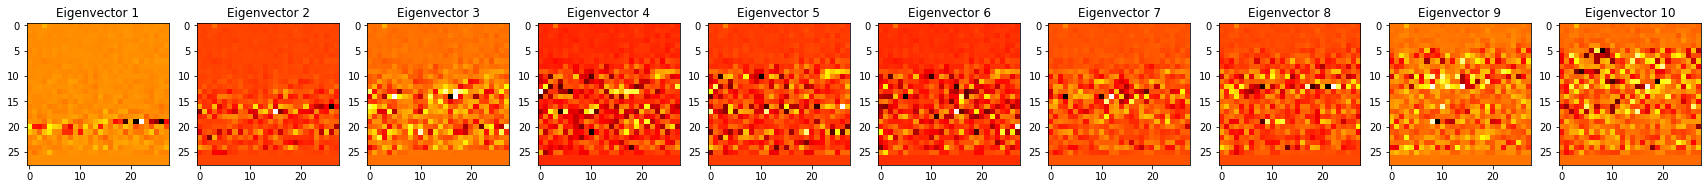

In [21]:
# First k eigenvectors (sorted from highest to lowest eigenvalue)
min_val, max_val = np.min(evecs[:10].real), np.max(evecs[:10].real)
plt.figure(figsize=(30,8))
for i in range(10):
    evec_norm = (evecs[i].real - min_val) / (max_val - min_val)
    plt.subplot(1, 10, i+1)
    plt.imshow(evec_norm.reshape(h,w), cmap='hot')
    plt.title("Eigenvector " + str(i+1))
plt.show()

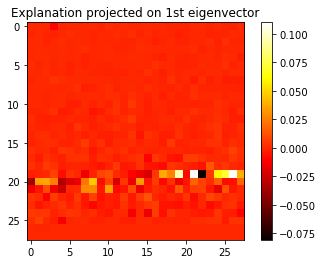

In [22]:
# Project explanation onto the dominant eigenvector
comp_on_projection = np.dot(explanation.numpy().flatten(), evecs[0].real)
projected_explanation = comp_on_projection * evecs[0].real

plt.imshow(projected_explanation.reshape(h,w), cmap='hot')
plt.title("Explanation projected on 1st eigenvector")
plt.colorbar()
plt.show()

### Compute variance empirically

In [23]:
num_perturbations = 10
perturbation_std = 0.1  # same as above for analytical formula
sigma_squared = perturbation_std ** 2

perturbed_explanations = []
for _ in range(num_perturbations):
    # Add Gaussian noise to the input image
    perturbed_image = sample_image + np.random.normal(0, perturbation_std, sample_image.shape)
    perturbed_image = np.clip(perturbed_image, 0, 1)  # Ensure valid pixel range

    # Generate explanation for perturbed input
    perturbed_explanation = explainer.explain(np.expand_dims(perturbed_image, axis=[0,3]), sample_label)
    perturbed_explanations.append(perturbed_explanation.numpy().flatten())

# Stack explanations and compute covariance matrix
explanation_matrix = np.stack(perturbed_explanations, axis=0)
empirical_covariance = np.cov(explanation_matrix, rowvar=False)

# Compute total variance (trace of the covariance matrix)
empirical_total_variance = np.trace(empirical_covariance)

print("Empirical Total Variance of Explanation:", empirical_total_variance)

Empirical Total Variance of Explanation: 45.94835350570945


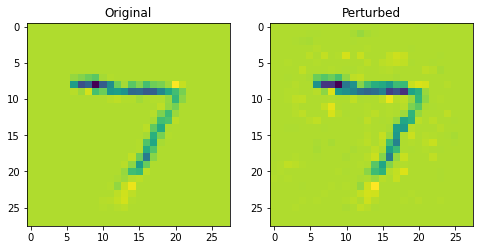

In [24]:
# Display explanation
plt.figure(figsize=(8,10))
plt.subplot(121)
plt.imshow(explanation[0]) # shape (1, 28, 28, 1)
plt.title("Original")
plt.subplot(122)
plt.imshow(perturbed_explanation[0]) # shape (1, 28, 28)
plt.title("Perturbed")
#plt.colorbar()
plt.show()

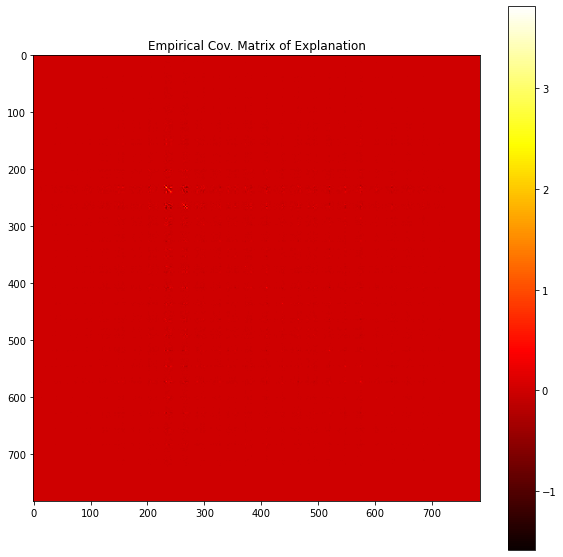

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(empirical_covariance, cmap='hot')
plt.title("Empirical Cov. Matrix of Explanation")
plt.colorbar()
plt.show()

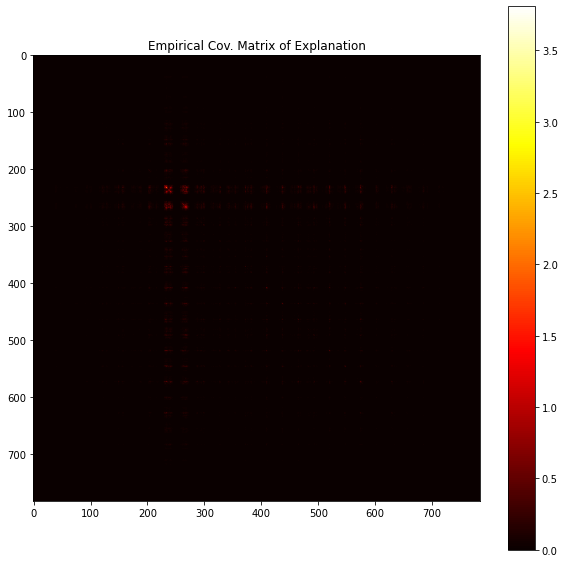

In [29]:
plt.figure(figsize=(10,10))
plt.imshow(np.abs(empirical_covariance), cmap='hot')
plt.title("Empirical Cov. Matrix of Explanation")
plt.colorbar()
plt.show()

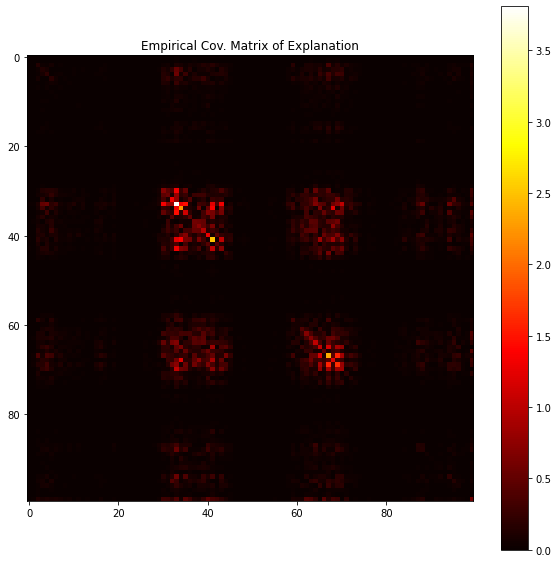

In [30]:
plt.figure(figsize=(10,10))
plt.imshow(np.abs(empirical_covariance)[200:300,200:300], cmap='hot')
plt.title("Empirical Cov. Matrix of Explanation")
plt.colorbar()
plt.show()

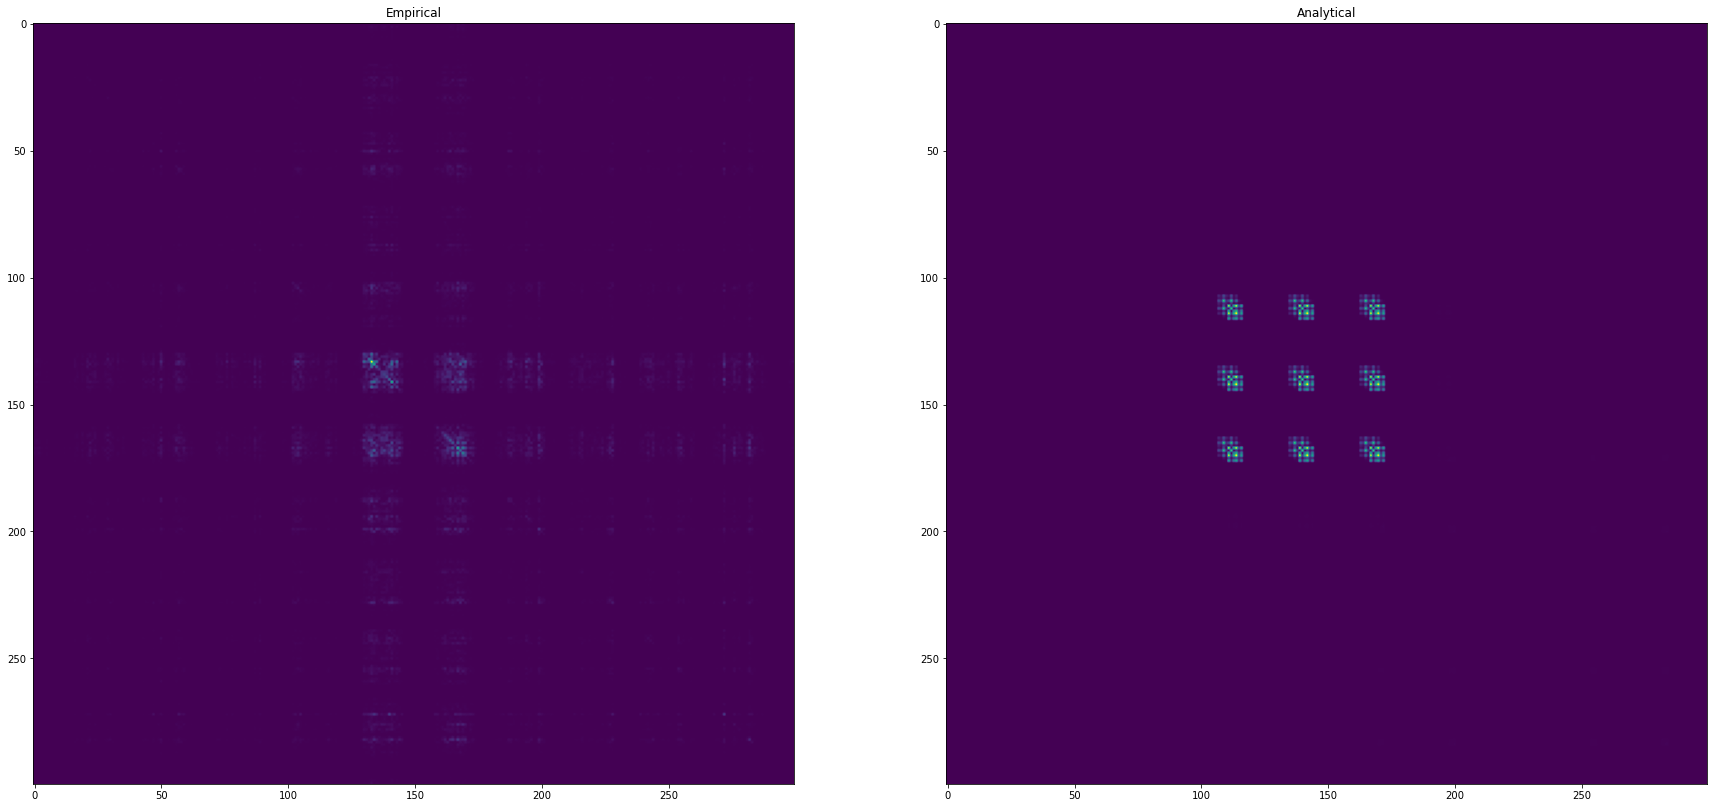

In [36]:
plt.figure(figsize=(30,30))
plt.subplot(121)
plt.imshow(np.abs(empirical_covariance)[100:400,100:400])#, cmap='hot')
plt.title("Empirical")
#plt.colorbar()
plt.subplot(122)
plt.imshow(np.abs(variance_explanation)[100:400,100:400])#, cmap='hot')
plt.title("Analytical")
#plt.colorbar()
plt.show()

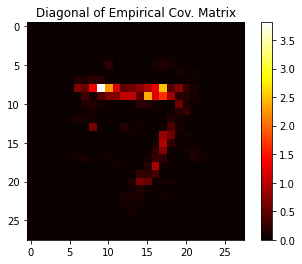

In [26]:
# Per Pixel Variance
plt.imshow(np.abs(np.diag(empirical_covariance).reshape(h,w)), cmap='hot')
plt.title("Diagonal of Empirical Cov. Matrix")
plt.colorbar()
plt.show()

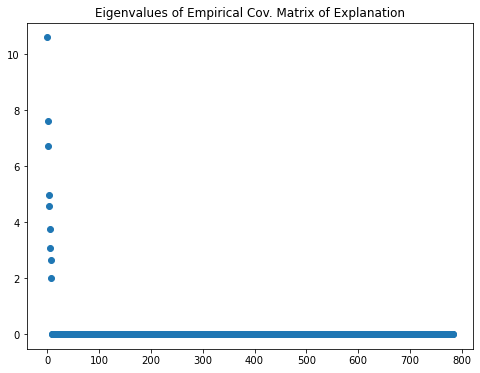

In [27]:
# Explained variance ratio
evals, evecs = np.linalg.eig(empirical_covariance)

plt.figure(figsize=(8,6))
plt.plot(evals, 'o')
plt.title('Eigenvalues of Empirical Cov. Matrix of Explanation');

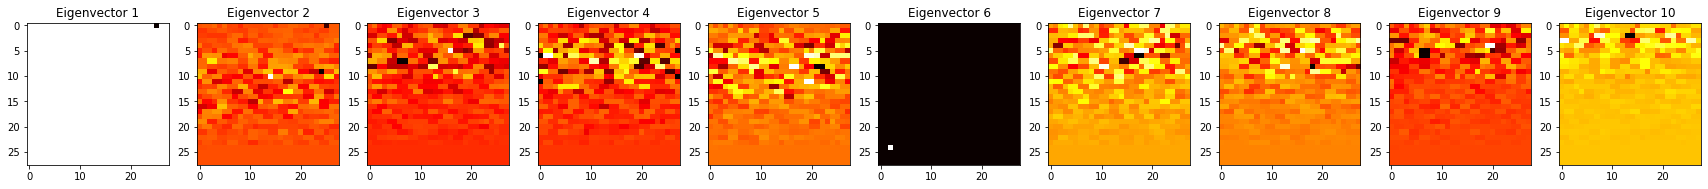

In [28]:
# First k eigenvectors (sorted from highest to lowest eigenvalue)
min_val, max_val = np.min(evecs[:10]), np.max(evecs[:10])
plt.figure(figsize=(30,8))
for i in range(10):
    evec_norm = (evecs[i] - min_val) / (max_val - min_val)
    plt.subplot(1, 10, i+1)
    plt.imshow(evec_norm.real.reshape(h,w), cmap='hot')
    plt.title("Eigenvector " + str(i+1))
plt.show()

### Analytical vs empirical (multiple methods, multiple variances)

In [15]:
explainers = [Saliency(model),
            GradientInput(model),
            IntegratedGradients(model, steps=80, batch_size=1),
            #SmoothGrad(model, nb_samples=80, batch_size=1), # takes long
            #SquareGrad(model, nb_samples=80, batch_size=1),
            #DeconvNet(model),
            #VarGrad(model, nb_samples=80, batch_size=1),
            #Lime(model, nb_samples = 80, batch_size=1),
            #KernelShap(model, nb_samples = 80, batch_size=1)
             ]

In [12]:
perturbed_image_pos.shape

(28, 28, 3)

In [16]:
stds = [0.1, 0.2, 0.3]#, 0.4, 0.5] # std. deviations
sample_image = sample_image.squeeze()
num_perturbations = 10 # for empirical cov.
dx = 1e-3 # differential for ana. cov.
h = w = sample_image.shape[0] # (28, 28, 3)
n = np.product(np.shape(sample_image)[:-1]) # for simplicity, treat RGB channels as one point/step
m = np.product(np.shape(explanation)) # (1, 28, 28, 1)

# Store results for plotting
results, cov_mats, jacobi_mats = {}, {}, {}

for explainer in explainers:
    name = explainer.__class__.__name__
    print('\n' + name)
    results[name]  = {'analytical': [], 'empirical': []}
    cov_mats[name] = {'analytical': [], 'empirical': []}
    
    # Precompute Jacobian (stays fixed for every std)
    derivative_e_x = np.zeros((m, n))
    # For every pixel perturbation, we get a new column in the Jacobian
    for i in range(h):
        for j in range(w):
            # Perturb pixel (i, j)
            perturbed_image_pos, perturbed_image_neg = np.copy(sample_image), np.copy(sample_image)
            perturbed_image_pos[i, j, :] += dx
            perturbed_image_neg[i, j, :] -= dx
            perturbed_image_pos = np.clip(perturbed_image_pos, 0, 1)  # Keep within valid range
            perturbed_image_neg = np.clip(perturbed_image_neg, 0, 1)

            # Compute explanation for perturbed image
            perturbed_explanation_pos = explainer(np.expand_dims(perturbed_image_pos, axis=0), sample_label)[0]
            perturbed_explanation_neg = explainer(np.expand_dims(perturbed_image_neg, axis=0), sample_label)[0]

            # Compute finite difference gradient
            gauss_perturbed_exp_pos = cv2.GaussianBlur(perturbed_explanation_pos.numpy(), (3,3), 6)
            gauss_perturbed_exp_neg = cv2.GaussianBlur(perturbed_explanation_neg.numpy(), (3,3), 6)

            # Normalize the explanations to [0, 1]
            normalized_perturbed_exp_pos = (gauss_perturbed_exp_pos - gauss_perturbed_exp_pos.min()) / (gauss_perturbed_exp_pos.max() - gauss_perturbed_exp_pos.min())
            normalized_perturbed_exp_neg = (gauss_perturbed_exp_neg - gauss_perturbed_exp_neg.min()) / (gauss_perturbed_exp_neg.max() - gauss_perturbed_exp_neg.min())

            # Fill out the corresponding column in the jacobian
            derivative_2d = (normalized_perturbed_exp_pos - normalized_perturbed_exp_neg) / (2*dx)
            flat_ind = i * w + j
            derivative_e_x[:, flat_ind] = derivative_2d.reshape(m, )
    jacobi_mats[name] = derivative_e_x
    
    for std in stds:
        ### Analytical
        sigma_squared = std ** 2
        covariance_ana = sigma_squared * derivative_e_x @ derivative_e_x.T
        
        # Total variance is the trace of the cov. matrix
        print("Analytical Variance (std = ", std, "):", np.trace(covariance_ana))
        results[name]['analytical'].append(np.trace(covariance_ana))
        cov_mats[name]['analytical'].append(covariance_ana)
        
        ### Empirical
        perturbed_explanations = []
        for _ in range(num_perturbations):
            # Add Gaussian noise to the input image
            perturbed_image = sample_image + np.random.normal(0, std, sample_image.shape)
            perturbed_image = np.clip(perturbed_image, 0, 1)  # Ensure valid pixel range

            # Generate explanation for perturbed input
            perturbed_explanation = explainer.explain(np.expand_dims(perturbed_image, axis=0), sample_label)
            perturbed_explanations.append(perturbed_explanation.numpy().flatten())
        
        # Stack explanations and compute covariance matrix
        explanation_matrix = np.stack(perturbed_explanations, axis=0).squeeze()
        covariance_emp = np.cov(explanation_matrix, rowvar=False)
        
        print("Empirical Variance (std = ", std, "):", np.trace(covariance_emp))
        results[name]['empirical'].append(np.trace(covariance_emp))
        cov_mats[name]['empirical'].append(covariance_emp)


Saliency
Analytical Variance (std =  0.1 ): 69831.76754743741
Empirical Variance (std =  0.1 ): 86.87113320854701
Analytical Variance (std =  0.2 ): 279327.07018974965
Empirical Variance (std =  0.2 ): 103.36073278102263
Analytical Variance (std =  0.3 ): 628485.9079269365
Empirical Variance (std =  0.3 ): 105.42794984590637

GradientInput
Analytical Variance (std =  0.1 ): 103.8777679060601
Empirical Variance (std =  0.1 ): 5.5914439273624446
Analytical Variance (std =  0.2 ): 415.5110716242404
Empirical Variance (std =  0.2 ): 11.996967699647696
Analytical Variance (std =  0.3 ): 934.8999111545409
Empirical Variance (std =  0.3 ): 18.46899328582104

IntegratedGradients
Analytical Variance (std =  0.1 ): 81.74221537932095
Empirical Variance (std =  0.1 ): 3.6482103760838482
Analytical Variance (std =  0.2 ): 326.9688615172838
Empirical Variance (std =  0.2 ): 8.187957383116034
Analytical Variance (std =  0.3 ): 735.6799384138883
Empirical Variance (std =  0.3 ): 13.461761891367729


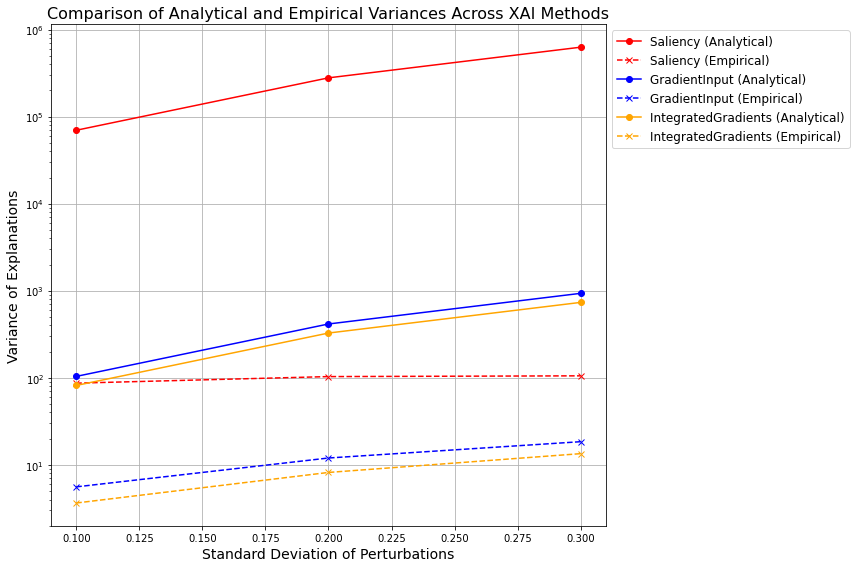

In [17]:
plt.figure(figsize=(12, 8))
colors=['red', 'blue', 'orange', 'green', 'black', 'brown', 'olive']
for (name, data), col in zip(results.items(), colors):
    plt.plot(stds, data['analytical'], marker='o', label=f"{name} (Analytical)", c=col)
    plt.plot(stds, data['empirical'],  marker='x', label=f"{name} (Empirical)", c=col, linestyle='dashed')

plt.xlabel('Standard Deviation of Perturbations', fontsize=14)
plt.yscale('log')
plt.ylabel('Variance of Explanations', fontsize=14)
plt.title('Comparison of Analytical and Empirical Variances Across XAI Methods', fontsize=16)
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

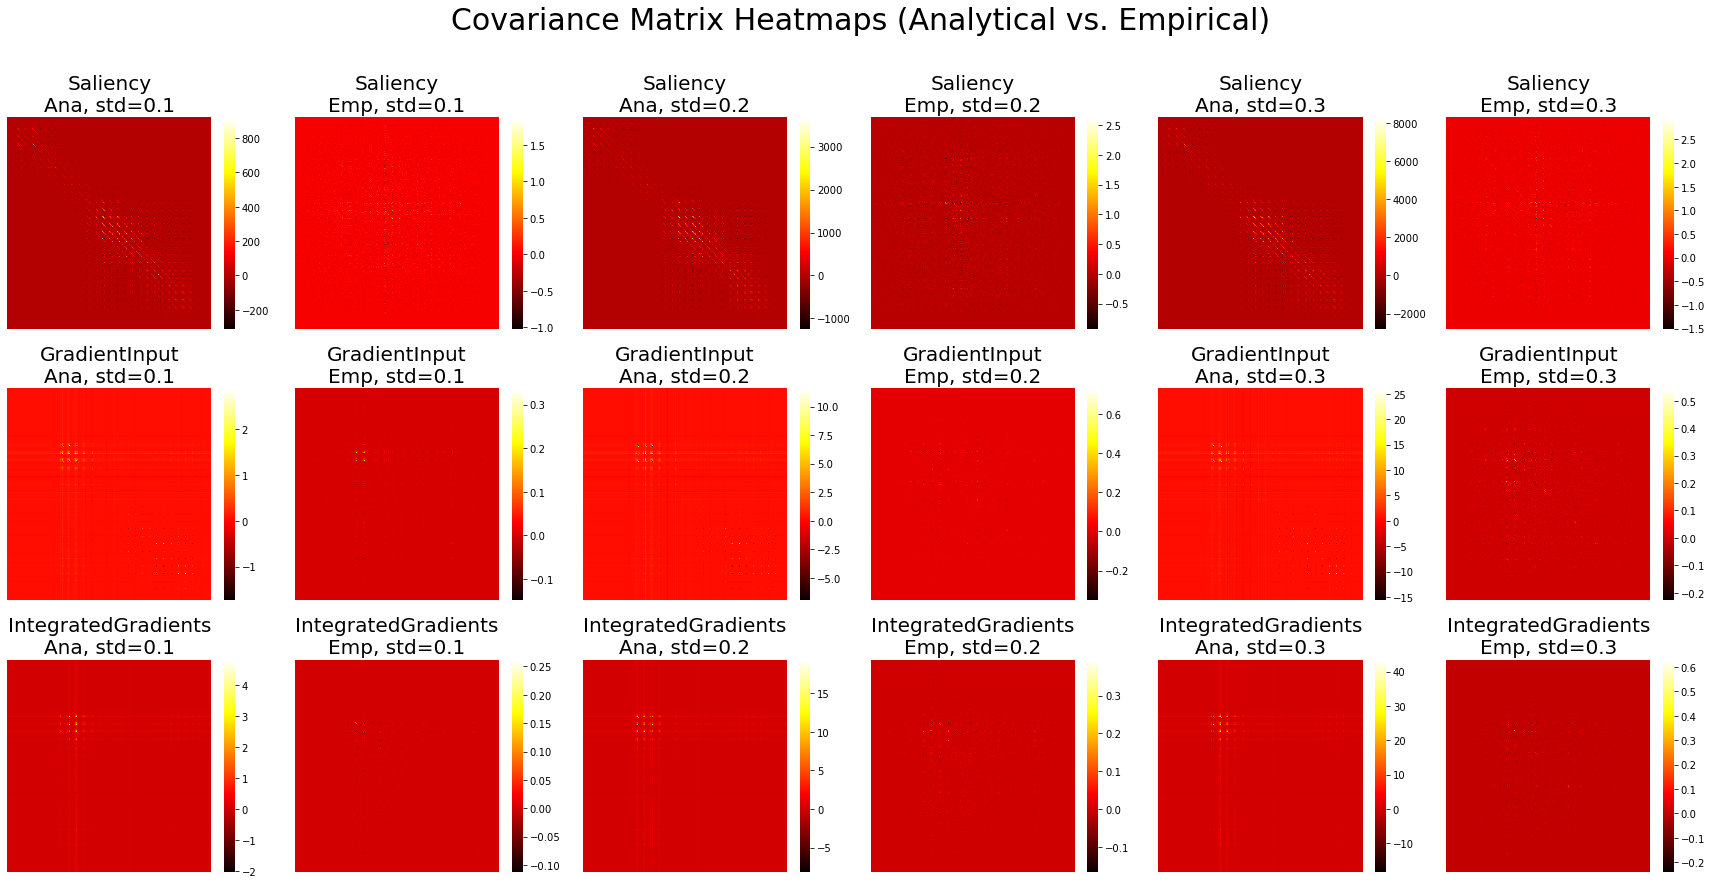

In [21]:
# Create heatmaps for all methods and perturbation stds
# Note: it may take 2 mins to display
def plot_heatmaps(cov_mats, stds):
    num_methods = len(cov_mats)
    num_stds = len(stds)

    fig, axes = plt.subplots(num_methods, num_stds * 2, figsize=(4 * num_stds * 2, 4 * num_methods))
    fig.suptitle('Covariance Matrix Heatmaps (Analytical vs. Empirical)', fontsize=30, y=1.02)

    for i, (name, cov_data) in enumerate(cov_mats.items()):
        for j, std in enumerate(stds):
            # Analytical covariance matrix
            cov_ana = cov_data['analytical'][j]
            ax = axes[i, j * 2]
            sns.heatmap(cov_ana, ax=ax, cmap="hot", xticklabels=False, yticklabels=False, cbar=True)
            ax.set_title(f"{name}\nAna, std={std}", fontsize=20)
            ax.tick_params(left=False, bottom=False)

            # Empirical covariance matrix
            cov_emp = cov_data['empirical'][j]
            ax = axes[i, j * 2 + 1]
            sns.heatmap(cov_emp, ax=ax, cmap="hot", xticklabels=False, yticklabels=False, cbar=True)
            ax.set_title(f"{name}\nEmp, std={std}", fontsize=20)
            ax.tick_params(left=False, bottom=False)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Call the function to generate heatmaps
plot_heatmaps(cov_mats, stds)

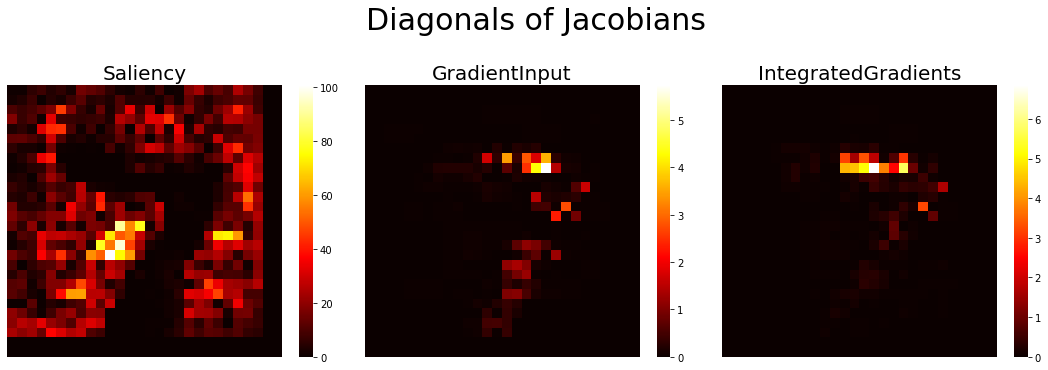

In [34]:
fig, axes = plt.subplots(1, len(jacobi_mats), figsize=(5*len(jacobi_mats), 5))
fig.suptitle('Diagonals of Jacobians', fontsize=30, y=1.02)

for i, (name, jmat) in enumerate(jacobi_mats.items()):
    ax = axes[i]
    sns.heatmap(np.abs(np.diag(jmat).reshape(h,w)), ax=ax, cmap="hot", xticklabels=False, yticklabels=False, cbar=True)
    ax.set_title(f"{name}", fontsize=20)
    ax.tick_params(left=False, bottom=False)
plt.tight_layout()
plt.show()